# Дипломная работа

## Установка модулей

In [ ]:
!pip install yfinance

In [ ]:
import numpy as np
import requests
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

## Загрузка и предобработка данных

In [ ]:
tickers = ['SBER.ME', 'NVTK.ME', 'MTSS.ME', 'POLY.ME', 'AFLT.ME', 'GAZP.ME', 'ROSN.ME', 'VTBR.ME', 'LKOH.ME', 'ALRS.ME',  'TATN.ME']
indicator = 'IMOEX.ME'
all = tickers + [indicator]

Загрузка цен (используются только цены закрытия дня)

In [ ]:
data = yf.download(all)['Close'].dropna()

[*********************100%***********************]  12 of 12 completed


In [ ]:
data

,AFLT.ME,ALRS.ME,GAZP.ME,IMOEX.ME,LKOH.ME,MTSS.ME,NVTK.ME,POLY.ME,ROSN.ME,SBER.ME,TATN.ME,VTBR.ME
Date,,,,,,,,,,,,
2013-06-20,52.549999,33.050999,108.239998,1296.380005,1865.099976,251.000000,326.019989,278.230011,220.529999,91.300003,182.710007,0.04696
2013-06-21,54.349998,33.055000,109.599998,1299.109985,1798.300049,249.520004,335.369995,262.380005,222.750000,91.500000,181.399994,0.04791
2013-06-24,53.410000,33.097000,107.230003,1292.369995,1787.900024,248.770004,348.970001,254.500000,227.000000,88.879997,184.179993,0.04709
2013-06-25,54.240002,33.047001,108.559998,1302.130005,1815.400024,250.399994,342.299988,252.169998,231.259995,89.570000,186.600006,0.04788
2013-06-26,55.299999,34.000000,110.050003,1321.869995,1866.699951,259.420013,347.000000,237.070007,228.500000,92.510002,188.389999,0.04920
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-11,35.459999,79.550003,234.550003,2557.159912,5190.000000,211.750000,1141.599976,925.000000,414.000000,138.690002,382.799988,0.02150
2022-04-12,34.060001,78.459999,236.300003,2540.989990,5145.000000,210.899994,1116.199951,936.700012,412.100006,135.380005,383.600006,0.02111
2022-04-13,33.860001,79.949997,234.869995,2528.419922,5106.000000,210.500000,1101.400024,918.700012,406.049988,135.500000,385.000000,0.02114


## Стратегии

### 1. Взвешенная доходность временных окон

Свободные параметры:

In [ ]:
lookbacks = (10, 30, 60, 110, 220)
weights = (.1, .15, .25, .25, .25)
count_to_invest = 2

Составление таблицы месячных доходностей для каждого актива

In [ ]:
data_month = data.iloc[max(lookbacks):].resample('BM').last().pct_change().dropna()+1
data_month.head()

,AFLT.ME,ALRS.ME,GAZP.ME,IMOEX.ME,LKOH.ME,MTSS.ME,NVTK.ME,POLY.ME,ROSN.ME,SBER.ME,TATN.ME,VTBR.ME
Date,,,,,,,,,,,,
2014-06-30,1.023209,1.012107,1.051235,1.030970,1.034553,1.069062,1.135135,1.061808,1.103097,1.000000,1.097872,0.858038
2014-07-31,0.895800,1.055024,0.886144,0.934455,0.982760,0.913579,0.870238,0.936273,0.894505,0.871006,0.959528,0.968370
2014-08-29,0.924431,0.963719,0.999621,1.015294,1.027038,1.021601,1.006840,1.065428,1.013453,0.994701,1.070925,0.964824
2014-09-30,0.925530,0.835294,1.045093,1.007396,0.980535,0.972079,1.110788,1.005163,1.026549,1.031553,1.017544,0.990625
2014-10-31,0.883237,1.084507,1.026106,1.054852,1.052109,0.930657,1.081415,1.094225,1.034052,1.009402,1.119828,1.049685


Составление списка торговых дат (сделка совершается раз в месяц)

In [ ]:
trade_dates = data_month.index.to_list()

In [ ]:
def weighted_timing_windows_returns(date):
  df = data[:date]
  performance_list = []
  for i, lookback in enumerate(lookbacks):
    current_price = df.iloc[-1]
    lag_price = df.iloc[-lookback]
    period_return = current_price / lag_price * weights[i]
    performance_list.append(period_return)
  performance = pd.concat(performance_list)
  performance = performance.groupby(performance.index).sum()
  if performance[indicator] < 1:
    strategy_return = 1
  else:
    performance = performance.drop(indicator).sort_values(ascending=False)[:count_to_invest] #выкидываем индикатор, так как не хотим его торговать
    asset_weights = performance / performance.sum()
    tickers_to_invest = performance.index.to_list()
    strategy_return = data_month[tickers_to_invest][date:].iloc[1] * asset_weights
    strategy_return = strategy_return.sum()
  return strategy_return

In [ ]:
weighted_timing_windows_returns = np.vectorize(weighted_timing_windows_returns)
returns = weighted_timing_windows_returns(trade_dates[:-1])

In [ ]:
returns = pd.Series(data = returns.cumprod(), index = trade_dates[:-1])

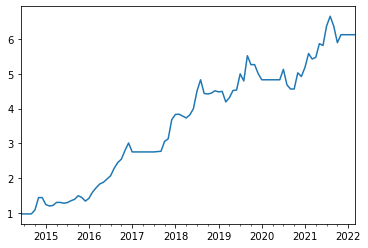

In [ ]:
returns.plot()

In [ ]:
max(returns)

6.6629789470492025

In [ ]:
min(returns)

0.9643000356366916

In [ ]:
returns[-1]

6.130531498582927

### 2. EMA-DEMA пересечения